In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, GroupKFold, StratifiedGroupKFold, KFold
import random
from collections import Counter
import joblib
import re
import matplotlib.pyplot as plt

### GET DFs - PER, CHRONOTOPE, TOPICS, BoW

#### DF_PER

In [2]:
df_PER = pd.read_csv(r'/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/PER_DOC2VEC_novels_chapitres_large')
df_PER.set_index("Titre du livre", inplace = True)
df_PER = df_PER.replace(np.nan, 0)

In [3]:
df_PER.index = [elem.split(".")[0] for elem in list(df_PER.index)]
df_PER = df_PER[~df_PER.index.duplicated(keep='first')]

In [4]:
df_PER.shape

(2949, 600)

#### DF_CHRONOTOPE

In [5]:
df_CHRONOTOPE = pd.read_csv(r'/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/CHRONOTOPE_CHAPITRES_DOC2VEC_novels_large')
df_CHRONOTOPE.set_index("Unnamed: 0", inplace = True)
df_CHRONOTOPE = df_CHRONOTOPE.replace(np.nan, 0)

In [6]:
df_CHRONOTOPE.index = [elem.split(".")[0] for elem in list(df_CHRONOTOPE.index)]
df_CHRONOTOPE = df_CHRONOTOPE[~df_CHRONOTOPE.index.duplicated(keep='first')]

In [7]:
df_CHRONOTOPE.shape

(2949, 1200)

#### DF_TOPICS

In [8]:
df_TOPICS = pd.read_csv(r'/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/TOPICS_chapitres.csv')
df_TOPICS.set_index("Class", inplace = True)
df_TOPICS = df_TOPICS.replace(np.nan, 0)

In [9]:
df_TOPICS.index = [elem.split(".")[0] for elem in list(df_TOPICS.index)]
df_TOPICS = df_TOPICS[~df_TOPICS.index.duplicated(keep='first')]

In [10]:
df_TOPICS.shape

(2950, 33)

#### DF_BoW

In [11]:
df_BoW = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/data/main_dataset_majed_canon_author_scale.csv')
df_BoW.set_index("index", inplace = True)
df_BoW = df_BoW.replace(np.nan, 0)

In [12]:
df_BoW = df_BoW.iloc[:, 0:2000]

In [13]:
df_BoW.index = [elem.split(".")[0] for elem in list(df_BoW.index)]
df_BoW = df_BoW[~df_BoW.index.duplicated(keep='first')]

In [14]:
df_BoW.shape

(2953, 2000)

### DF MAIN : ALL CONCATENATED DFs

In [15]:
def get_common_items(list1, list2, list3, list4):
    # Find the intersection of all four lists
    common_items = list(set(list1) & set(list2) & set(list3) & set(list4))
    all_items = set([*list1, *list2, *list3, *list4] )

    faulty_items = [elem for elem in all_items if elem not in common_items]
    
    return common_items, faulty_items, all_items


In [16]:
common_items, faulty_items, all_items = get_common_items(df_PER.index, df_CHRONOTOPE.index, df_TOPICS.index, df_BoW.index)

In [17]:
print(len(common_items), len(faulty_items), len(all_items))

2940 19 2959


In [18]:
faulty_items

['1918_Proust-Marcel_A-l-ombre-des-jeunes-filles-en-fleurs',
 '1913_Proust-Marcel_Du-cote-de-chez-Swann-A-la-recherche-du-temps-perdu',
 '1869_Hugo-Victor_L-homme-qui-rit',
 '1923_Proust-Marcel_La-Prisonniere-A-la-recherche-du-temps-perdu',
 '1913_Proust-Marcel_Du-cote-de-chez-Swann',
 '1927_Proust-Marcel_Le-Temps-retrouve-A-la-recherche-du-temps-perdu',
 '1927_Proust-Marcel_Le-Temps-retrouve',
 '1884_Gouraud-Julie_La-petite-maîtresse-de-maison',
 '1909_Dhanys-Marcel_La-fille-de-Racine',
 '2009_Simon-Claude_Archipel-et-Nord',
 '2009_Carrere-Emmanuel_D-autres-vies-que-la-mienne',
 '2001_Modiano-Patrick_La-Petite-Bijou',
 '1876_d-Ennery-Adolphe_Les-deux-orphelines',
 "1869_Hugo-Victor_L'homme-qui-rit",
 '1923_Proust-Marcel_La-Prisonniere',
 '1921_Proust-Marcel_Sodome-et-Gomorrhe-A-la-recherche-du-temps-perdu',
 '1918_Proust-Marcel_A-l-ombre-des-jeunes-filles-en-fleurs-A-la-recherche-du-temps-perdu',
 '1921_Proust-Marcel_Sodome-et-Gomorrhe',
 '2001_Houellebecq-Michel_Plateforme']

In [19]:
print(df_PER.shape, df_CHRONOTOPE.shape, df_BoW.shape, df_TOPICS.shape)

(2949, 600) (2949, 1200) (2953, 2000) (2950, 33)


In [20]:
df_CHRONOTOPE.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_TOPICS.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_BoW.drop(faulty_items, axis=0, inplace=True, errors='ignore')
df_PER.drop(faulty_items, axis=0, inplace=True, errors='ignore')

In [21]:
df_MAIN = pd.concat([df_PER, df_CHRONOTOPE, df_TOPICS, df_BoW], axis=1)

In [22]:
df_MAIN.to_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF.csv', index=True)

In [23]:
df_MAIN_sans_topics = pd.concat([df_PER, df_CHRONOTOPE, df_BoW], axis=1)

In [24]:
df_MAIN_sans_topics.to_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF_sans_topics.csv', index=True)

In [25]:
df_MAIN_sans_topics.shape

(2940, 3800)

## GET GENRES

In [26]:
df_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/corpus.csv')
df_corpus.set_index(['doc_name'], inplace=True)

In [27]:
def get_df_with_subgenre(df, df_corpus):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_subgenre.append(df_corpus.loc[elem].genre)
        else:
            list_subgenre.append('')
    df_res['subgenre'] = list_subgenre

    return df_res

In [28]:
df_MAIN_genred = get_df_with_subgenre(df_MAIN, df_corpus)

In [29]:
df_MAIN_genred.subgenre.value_counts()

subgenre
roman d'aventures               362
policier                        297
roman historique                204
nouvelles                       185
cycles et séries                169
littérature jeunesse            145
mémoires et autobiographie      136
roman sentimental               130
érotisme                        104
fantastique                      66
récit de voyage                  34
science-fiction                  31
                                 29
épistolaire                      28
non-fiction                      25
fragments                        16
journal intime                    8
biographie                        5
roman historique                  3
 mémoires et autobiographie       2
 nouvelles                        2
 littérature jeunesse             1
 roman sentimental                1
littérature jeunesse              1
ciné-roman                        1
littérature à contraintes         1
Name: count, dtype: int64

In [30]:
genres_ok = ["roman d'aventures",
'roman historique',
'policier',
'littérature jeunesse',
'mémoires et autobiographie',
'roman sentimental']

In [31]:
df_MAIN_genred_ok = df_MAIN_genred[df_MAIN_genred.subgenre.isin(genres_ok)]

In [32]:
#df_MAIN_genred_ok.to_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF_subgenred.csv', index=True)

In [33]:
len(df_MAIN_genred_ok)

1274

In [34]:
df_MAIN_genred_ok.subgenre.value_counts()

subgenre
roman d'aventures             362
policier                      297
roman historique              204
littérature jeunesse          145
mémoires et autobiographie    136
roman sentimental             130
Name: count, dtype: int64

In [35]:
def balance_dataframe(df, subgenre_column, N):
    # Count the occurrences of each subgenre
    subgenre_counts = df[subgenre_column].value_counts()
    
    # Determine the minimum count among all subgenres
    min_count = N
    
    # Create an empty DataFrame to store the balanced samples
    balanced_df = pd.DataFrame()
    
    # Iterate over each subgenre
    for i, subgenre in enumerate(subgenre_counts.index):
        # Sample `min_count` number of rows for each subgenre
        sampled_rows = df[df[subgenre_column] == subgenre].sample(n=min(min_count, subgenre_counts.values[i]), random_state=42)
        
        # Append the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sampled_rows])
    
    return shuffle(balanced_df)

In [36]:
df_MAIN_balanced = balance_dataframe(df_MAIN_genred_ok, 'subgenre', 130)

In [37]:
df_MAIN_balanced.subgenre.value_counts()

subgenre
policier                      130
roman d'aventures             130
mémoires et autobiographie    130
roman sentimental             130
roman historique              130
littérature jeunesse          130
Name: count, dtype: int64

In [38]:
df_MAIN_balanced.to_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF_BALANCED.csv', index=True)

### SVM PIPELINE

In [39]:
def plot_coefficients(coefs, feature_names, current_class, top_features=10):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 15))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Coefficients for "+current_class)
    plt.savefig('coefs_' + current_class + '.png')

In [40]:
def KF_canonized(df_main, n_splits=5, probas=False, kernel='rbf', get_coefs=False):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_INDEX = [] # lists of all test probas and all test index
    ALL_PROBA_AVENTURES, ALL_PROBA_JEUNESSE, ALL_PROBA_POLICIER, ALL_PROBA_AUTOBIO, ALL_PROBA_SENTIMENT = [], [], [], [], []    
    
    pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=probas))
    kf = KFold(n_splits)
    
    for (train_index, test_index) in kf.split(df_main.drop(['subgenre'], axis=1), df_main['subgenre']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['subgenre'], axis=1)
            y_train = train['subgenre']
            X_test = test.drop(['subgenre'], axis=1)
            y_test = test['subgenre']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)
                ALL_PROBA_JEUNESSE.extend(probs[:,0])
                ALL_PROBA_AUTOBIO.extend(probs[:,1])
                ALL_PROBA_POLICIER.extend(probs[:,2])
                ALL_PROBA_AVENTURES.extend(probs[:,3])
                ALL_PROBA_SENTIMENT.extend(probs[:,4])
        
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS, xticks_rotation="vertical")

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
     
    if get_coefs:
        if kernel != "linear":
            print(".......... COEFS ARE ONLY IMPLEMENTED FOR linearSVC ........")

        else:
            if len(pipe.classes_) == 2:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 index=[pipe.classes_[0]],
                                 columns=X_train.columns+['subgenre']).to_csv("coefficients_1V1.csv")

                plot_coefficients(pipe.named_steps['svc'].coef_[0], X_train.columns, pipe.classes_[0] + " versus " + pipe.classes_[1])

            else:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 #index=pipe.classes_,
                                 columns=X_train.columns+['subgenre']).to_csv("coefficients_subgenres.csv")

                for i in range(len(pipe.classes_)):
                    plot_coefficients(pipe.named_steps['svc'].coef_[i], X_train.columns, pipe.classes_[i])
            
    if probas:
        
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_jeunesse'] = ALL_PROBA_JEUNESSE
        df_results['proba_aventures'] = ALL_PROBA_AVENTURES
        df_results['proba_policier'] = ALL_PROBA_POLICIER
        df_results['proba_autobio'] = ALL_PROBA_AUTOBIO
        df_results['proba_sentiment'] = ALL_PROBA_SENTIMENT
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

### MULTICLASS CLASSIFICATION SUBGENRES

In [41]:
print(df_PER.shape, df_CHRONOTOPE.shape, df_TOPICS.shape, df_BoW.shape)

(2940, 600) (2940, 1200) (2940, 33) (2940, 2000)


### RESULTS PER

In [42]:
df_PER = df_MAIN_genred_ok.iloc[:, 0:600]
df_PER['subgenre'] = df_MAIN_genred_ok['subgenre']

0.24866411943217417


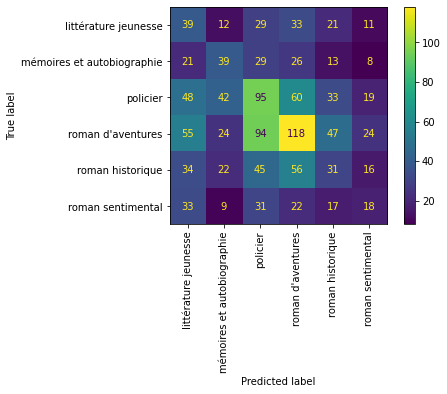

In [43]:
pipe, df_scores, bas = KF_canonized(df_PER, kernel="linear")

In [44]:
df_PER = df_MAIN_balanced.iloc[:, 0:600]
df_PER['subgenre'] = df_MAIN_balanced['subgenre']

0.26282051282051283


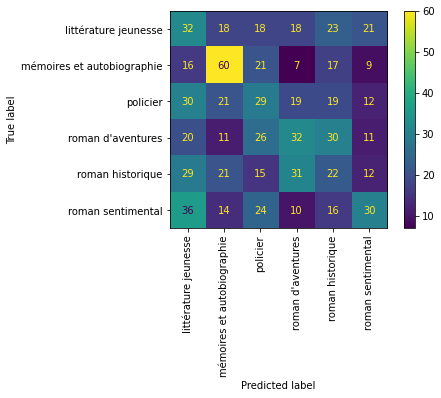

In [45]:
pipe, df_scores, bas = KF_canonized(df_PER, kernel="linear")

### RESULTS CHRONOTOPE

In [46]:
df_CHRONOTOPE = df_MAIN_genred_ok.iloc[:, 600:1800]
df_CHRONOTOPE['subgenre'] = df_MAIN_genred_ok['subgenre']

0.47636504234265153


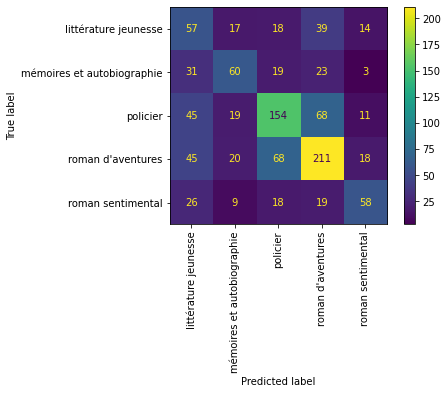

In [127]:
pipe, df_scores, bas = KF_canonized(df_CHRONOTOPE, kernel="linear")

In [47]:
df_CHRONOTOPE = df_MAIN_balanced.iloc[:, 600:1800]
df_CHRONOTOPE['subgenre'] = df_MAIN_balanced['subgenre']

0.44358974358974357


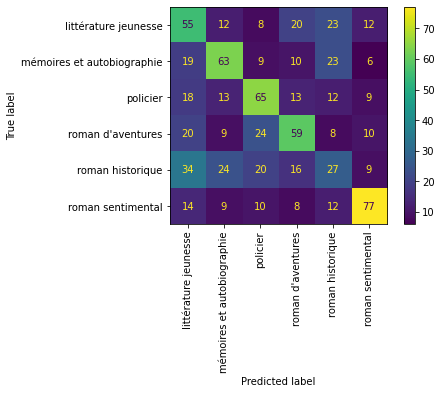

In [48]:
pipe, df_scores, bas = KF_canonized(df_CHRONOTOPE, kernel="linear")

### RESULTS TOPICS

In [49]:
df_TOPICS = df_MAIN_genred_ok.iloc[:, 1800:1833]
df_TOPICS['subgenre'] = df_MAIN_genred_ok['subgenre']

0.551504114575045


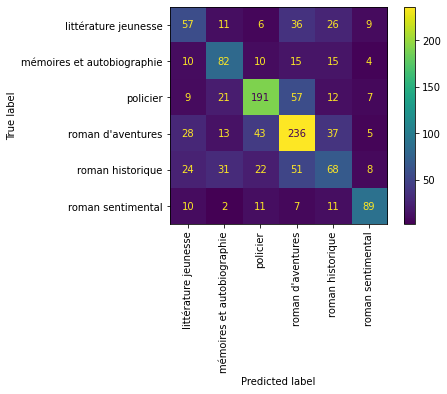

In [50]:
pipe, df_scores, bas = KF_canonized(df_TOPICS, kernel="linear")

In [51]:
df_TOPICS = df_MAIN_balanced.iloc[:, 1800:1833]
df_TOPICS['subgenre'] = df_MAIN_balanced['subgenre']

0.591025641025641


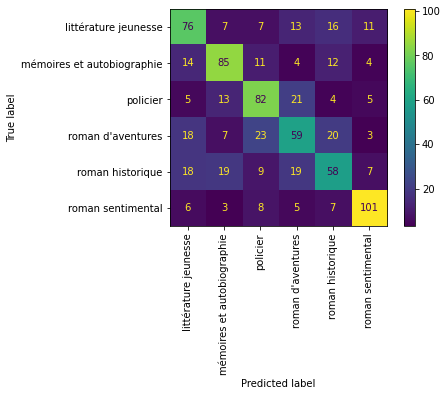

In [52]:
pipe, df_scores, bas = KF_canonized(df_TOPICS, kernel="linear")

### RESULTS BoW

In [53]:
df_BoW = df_MAIN_genred_ok.iloc[:, 1833:]

0.7180888886602673


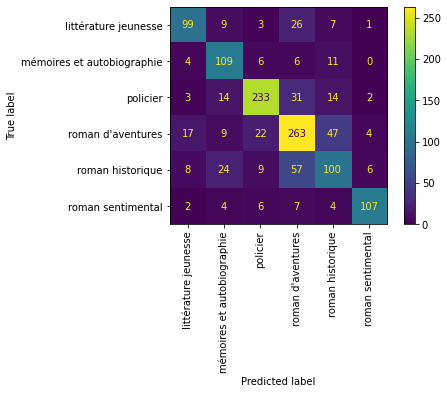

In [54]:
pipe, df_scores, bas = KF_canonized(df_BoW, kernel="linear")

In [55]:
df_BoW = df_MAIN_balanced.iloc[:, 1833:]

0.7884615384615384


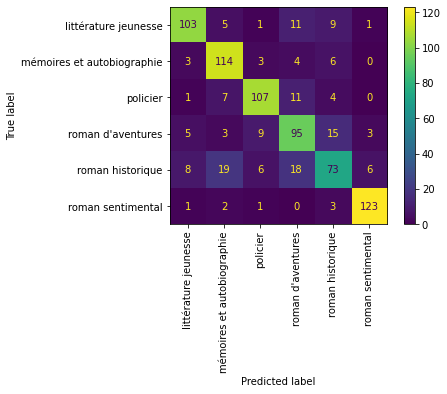

In [56]:
pipe, df_scores, bas = KF_canonized(df_BoW, kernel="linear")

### RESULTS MAIN

0.7020662771846471


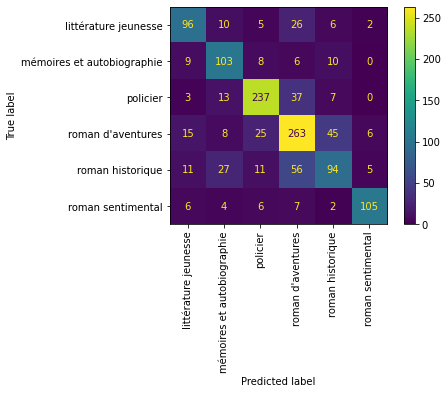

In [57]:
pipe, df_scores, bas = KF_canonized(df_MAIN_genred_ok, kernel="linear")

In [338]:
df_scores

,precision,recall,f1-score,support
littérature jeunesse,0.794393,0.586207,0.674603,145.000000
mémoires et autobiographie,0.789474,0.661765,0.720000,136.000000
policier,0.851711,0.754209,0.800000,297.000000
roman d'aventures,0.590226,0.867403,0.702461,362.000000
roman historique,0.555556,0.392157,0.459770,204.000000
roman sentimental,0.938596,0.823077,0.877049,130.000000
accuracy,0.706436,0.706436,0.706436,0.706436


0.7666666666666667


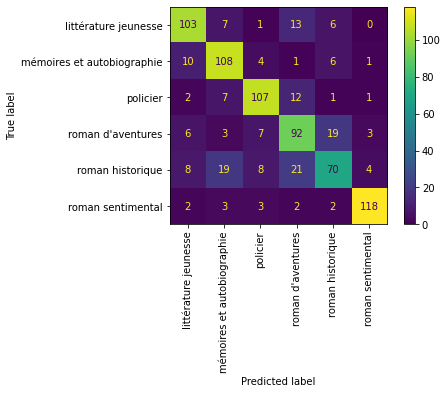

In [58]:
pipe, df_scores, bas = KF_canonized(df_MAIN_balanced, kernel="linear")

0.8600000000000001


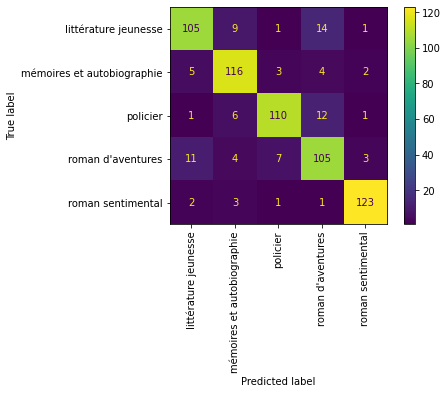

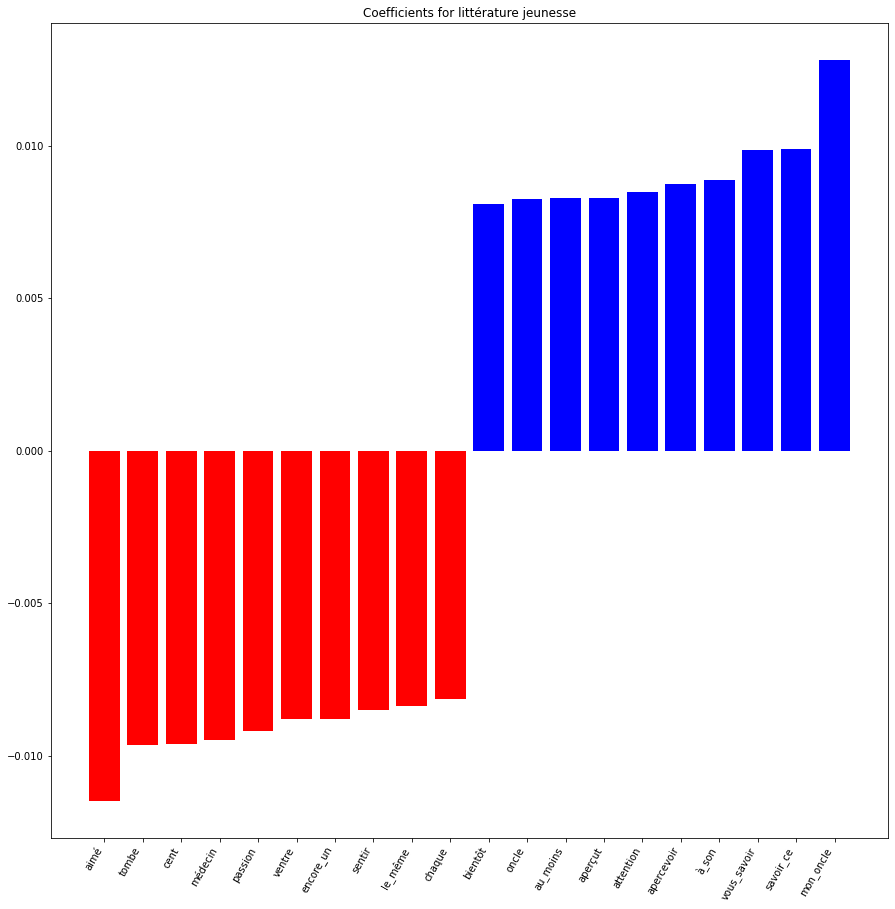

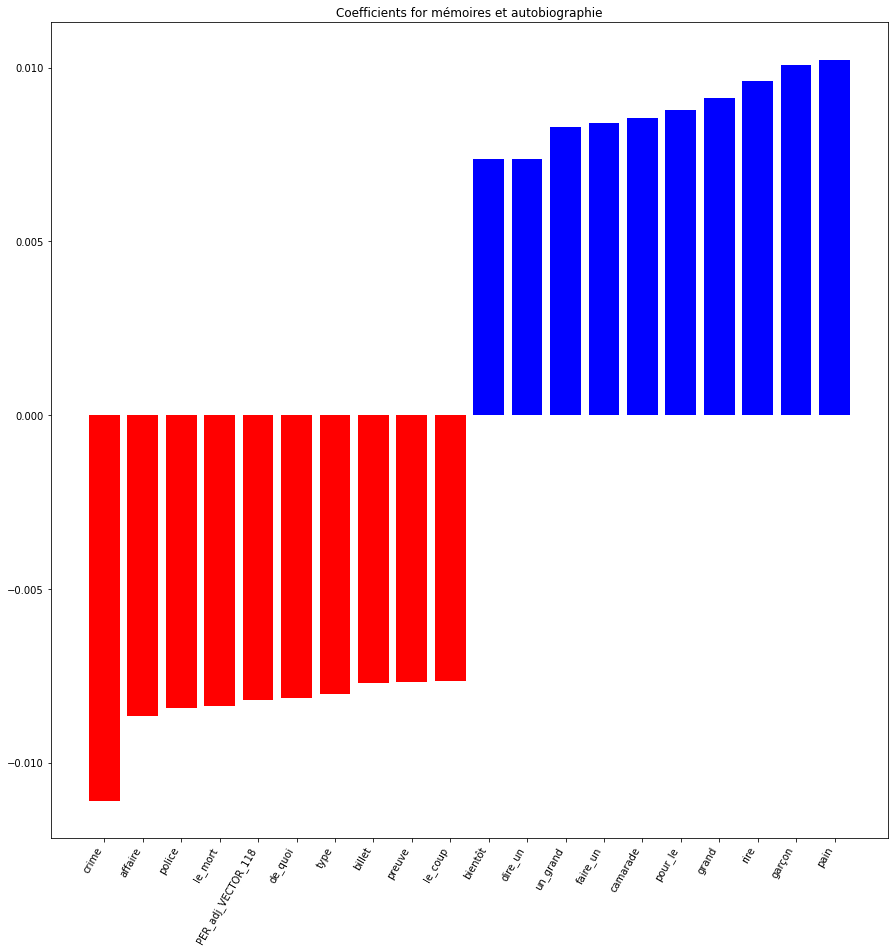

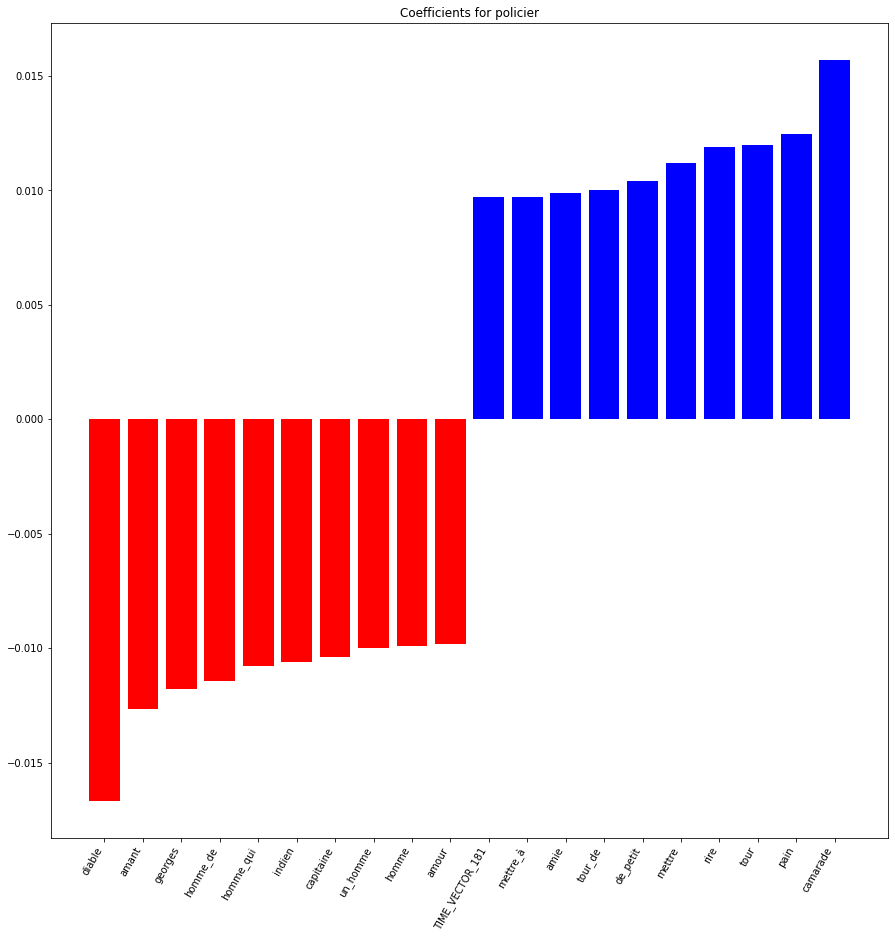

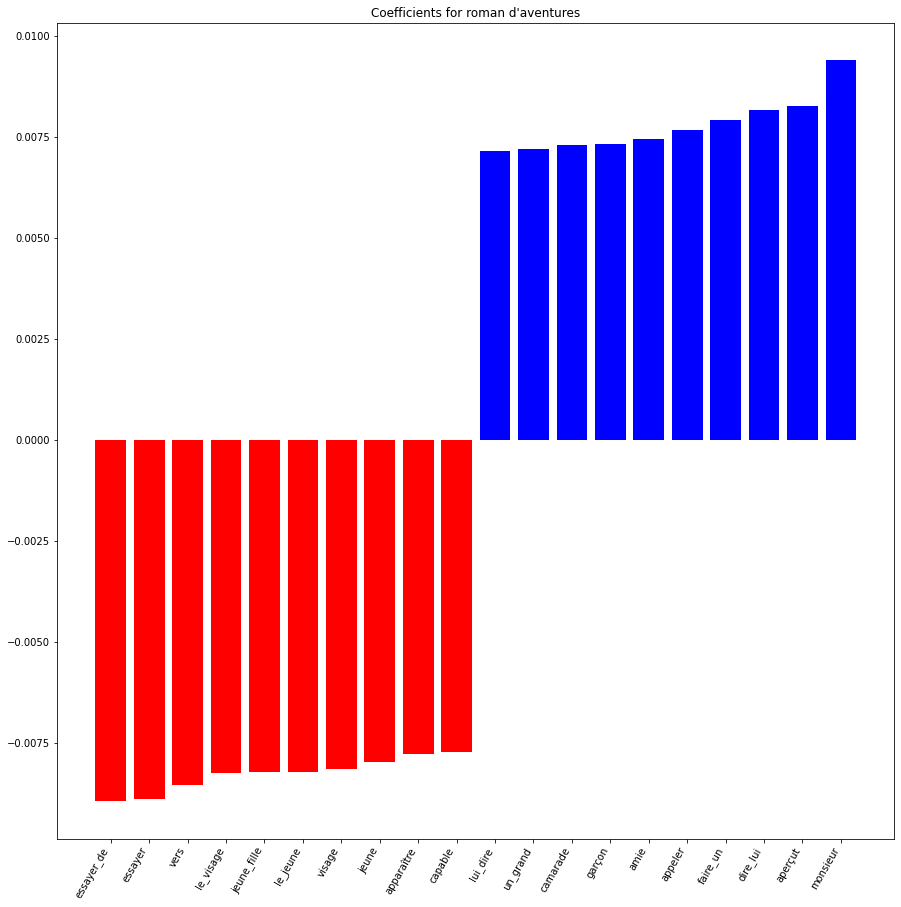

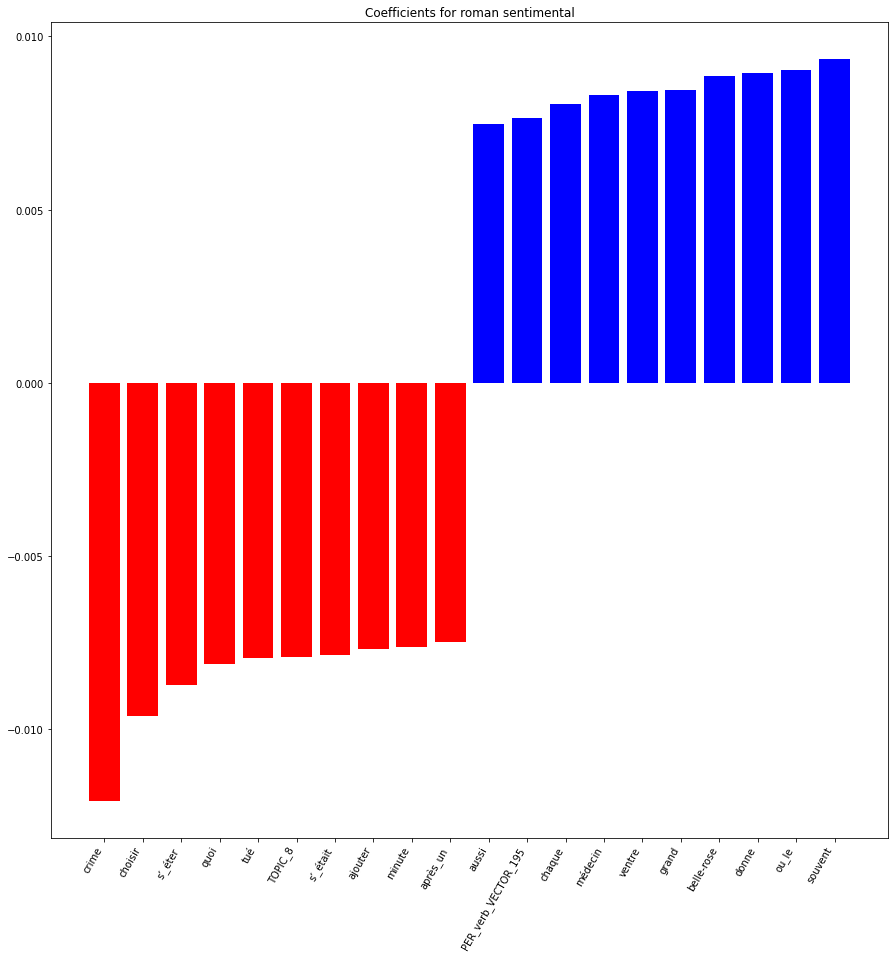

In [124]:
pipe, df_scores, bas = KF_canonized(df_MAIN_balanced, kernel="linear", get_coefs=True)

In [ ]:
# FIX GET COEFS

0.8600000000000001


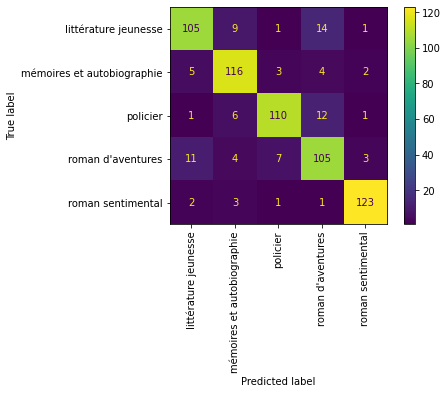

In [80]:
pipe, df_scores, bas, df_res = KF_canonized(df_MAIN_balanced, probas=True, kernel="linear")#get_coefs=True, 

In [83]:
df_res.to_csv("PROBAS_PREDS_SUBGENRES.csv", index=True)

In [301]:
df_unigram = df_MAIN_genred_ok.iloc[:, 1833:2300]
df_unigram['subgenre'] = df_MAIN_genred_ok['subgenre']

0.6941063759823822


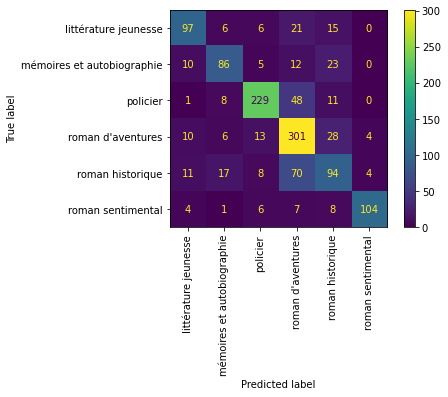

In [302]:
pipe, df_scores, bas = KF_canonized(df_unigram)

### MULTICLASS CLASSIFICATION AUTHORS

In [34]:
def GKF_canonized(df_main, n_splits=5, probas=False, kernel='rbf', get_coefs=False):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    ALL_PROBA_AVENTURES, ALL_PROBA_JEUNESSE, ALL_PROBA_POLICIER, ALL_PROBA_AUTOBIO, ALL_PROBA_SENTIMENT = [], [], [], [], []    

    pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, class_weight="balanced", probability=probas))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'subgenre'], axis=1), df_main['subgenre'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'subgenre'], axis=1)
            y_train = train['subgenre']
            X_test = test.drop(['auteur', 'subgenre'], axis=1)
            y_test = test['subgenre']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)
                ALL_PROBA_JEUNESSE.extend(probs[:,0])
                ALL_PROBA_AUTOBIO.extend(probs[:,1])
                ALL_PROBA_POLICIER.extend(probs[:,2])
                ALL_PROBA_AVENTURES.extend(probs[:,3])
                ALL_PROBA_SENTIMENT.extend(probs[:,4])
        
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS, xticks_rotation="vertical")

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
     
    if get_coefs:
        if kernel != "linear":
            print(".......... COEFS ARE ONLY IMPLEMENTED FOR linearSVC ........")

        else:
            if len(pipe.classes_) == 2:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 index=[pipe.classes_[0]],
                                 columns=X_train.columns).to_csv("coefficients_1V1.csv")

                plot_coefficients(pipe.named_steps['svc'].coef_[0], X_train.columns, pipe.classes_[0] + " versus " + pipe.classes_[1])

            else:
                pd.DataFrame(pipe.named_steps['svc'].coef_,
                                 #index=pipe.classes_,
                                 columns=X_train.columns).to_csv("coefficients_subgenres.csv")

                for i in range(len(pipe.classes_)):
                    plot_coefficients(pipe.named_steps['svc'].coef_[i], X_train.columns, pipe.classes_[i])
            
    if probas:
        
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_jeunesse'] = ALL_PROBA_JEUNESSE
        df_results['proba_aventures'] = ALL_PROBA_AVENTURES
        df_results['proba_policier'] = ALL_PROBA_POLICIER
        df_results['proba_autobio'] = ALL_PROBA_AUTOBIO
        df_results['proba_sentiment'] = ALL_PROBA_SENTIMENT
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

In [35]:
def get_df_with_authors(df):
    df_res = df.copy()
    list_author = []
    for elem in df_res.index:
        list_author.append(elem.split('_')[1])
    print(len(set(list_author)))
    df_res['auteur'] = list_author

    return df_res

In [36]:
df_MAIN_authored_genred_ok = get_df_with_authors(df_MAIN_genred_ok)

294


0.6580363436171265


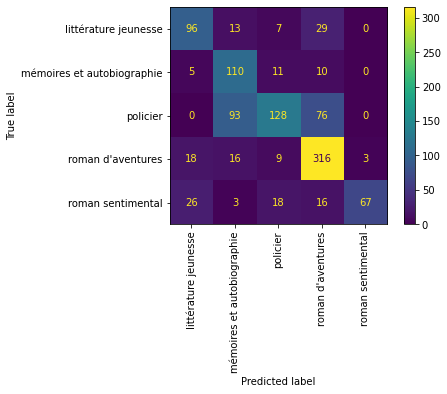

In [37]:
pipe, df_scores, bas = GKF_canonized(df_MAIN_authored_genred_ok)

In [264]:
df_scores

,precision,recall,f1-score,support
littérature jeunesse,0.659722,0.655172,0.657439,145.000000
mémoires et autobiographie,0.662252,0.735294,0.696864,136.000000
policier,0.733696,0.454545,0.561331,297.000000
roman d'aventures,0.659472,0.759669,0.706033,362.000000
roman historique,0.373377,0.563725,0.449219,204.000000
roman sentimental,0.957143,0.515385,0.670000,130.000000
accuracy,0.617739,0.617739,0.617739,0.617739


In [38]:
df_balanced = balance_dataframe(df_MAIN_authored_genred_ok, 'subgenre', 130)

In [39]:
df_balanced.subgenre.value_counts()

subgenre
mémoires et autobiographie    130
roman sentimental             130
policier                      130
littérature jeunesse          130
roman d'aventures             130
Name: count, dtype: int64

0.6707692307692308


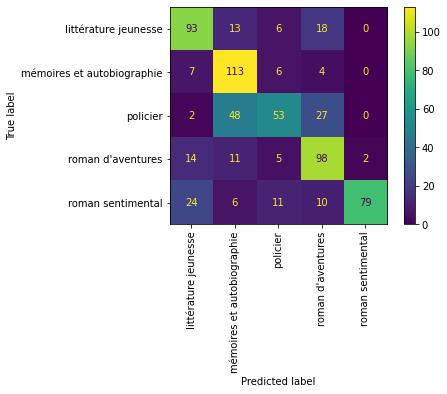

In [40]:
pipe, df_scores, bas = GKF_canonized(df_balanced)

0.7492307692307694


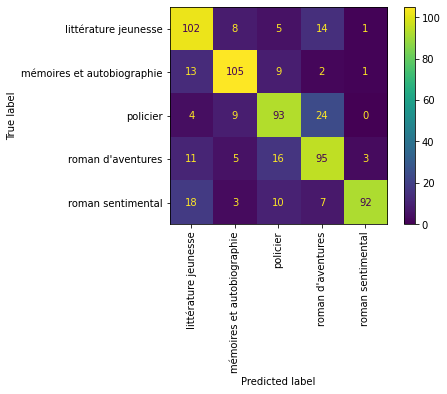

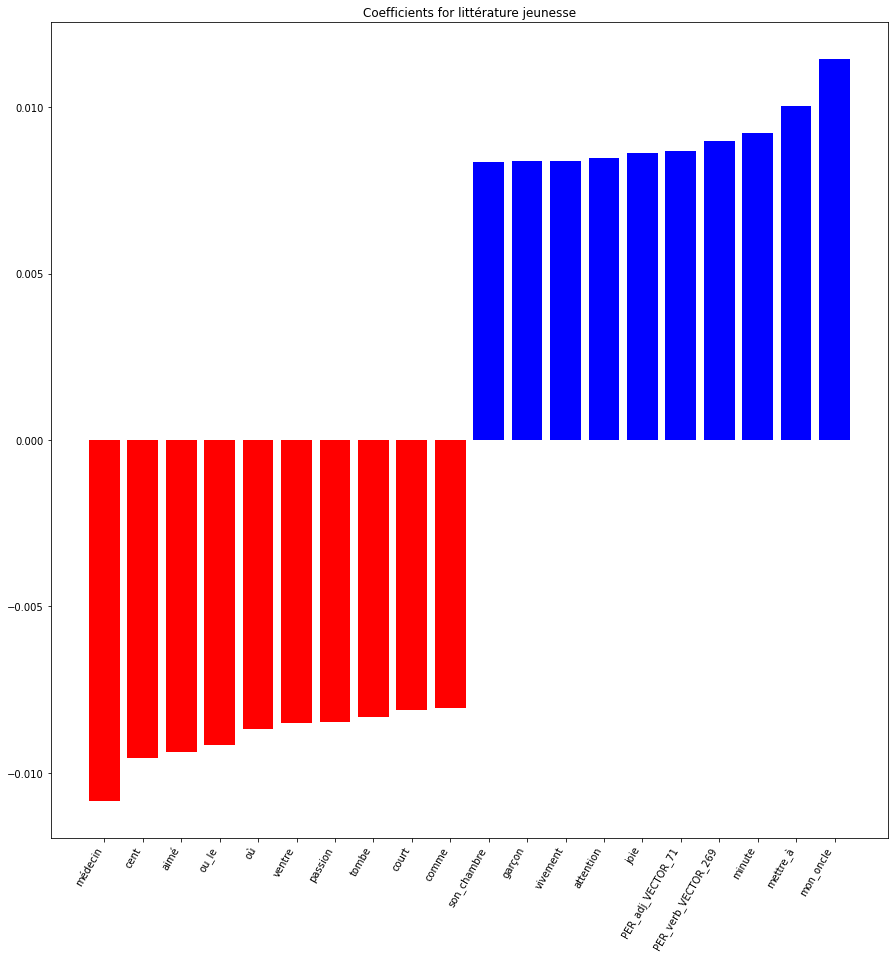

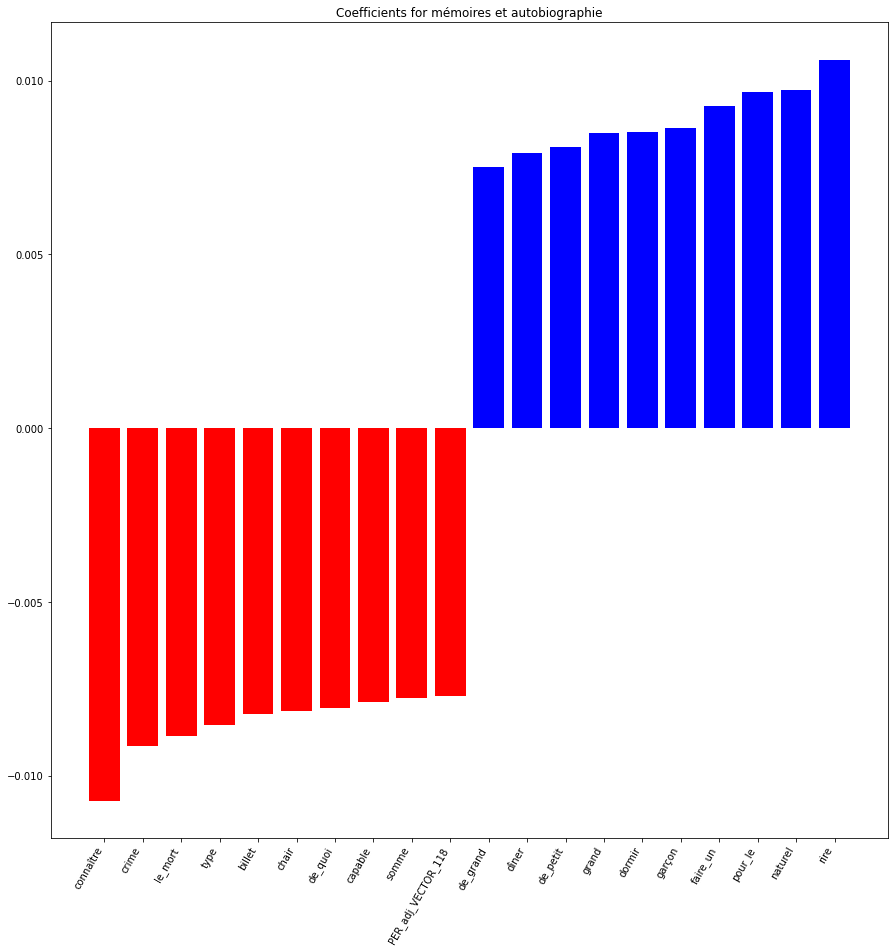

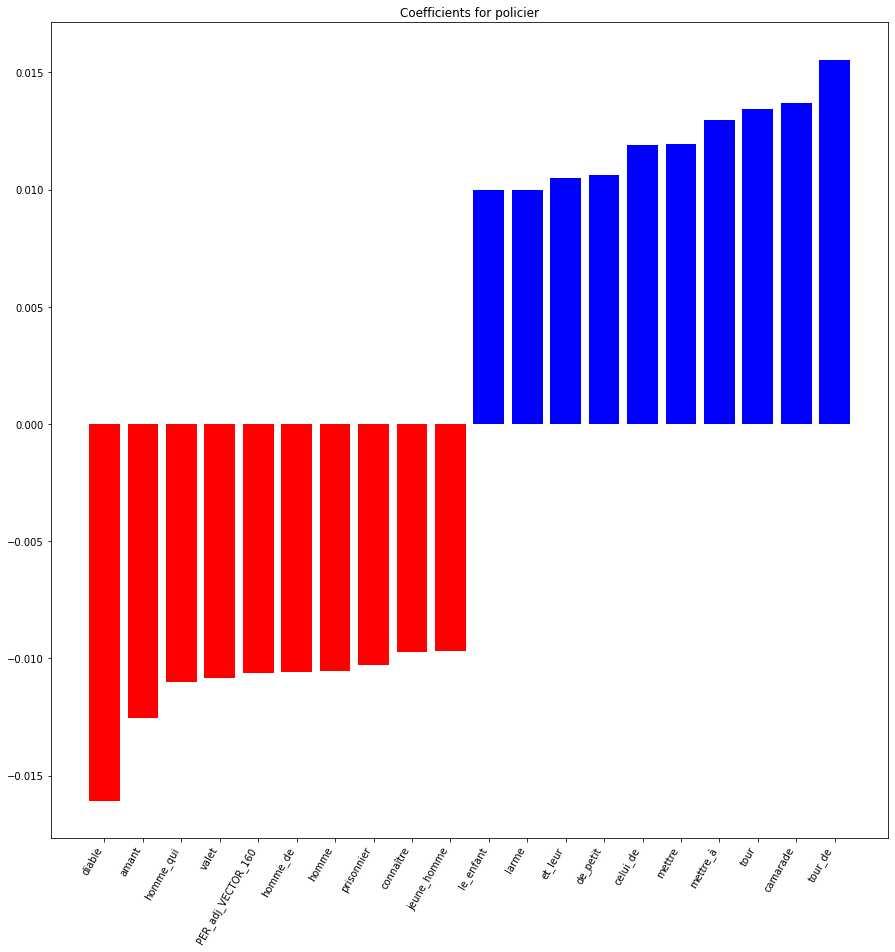

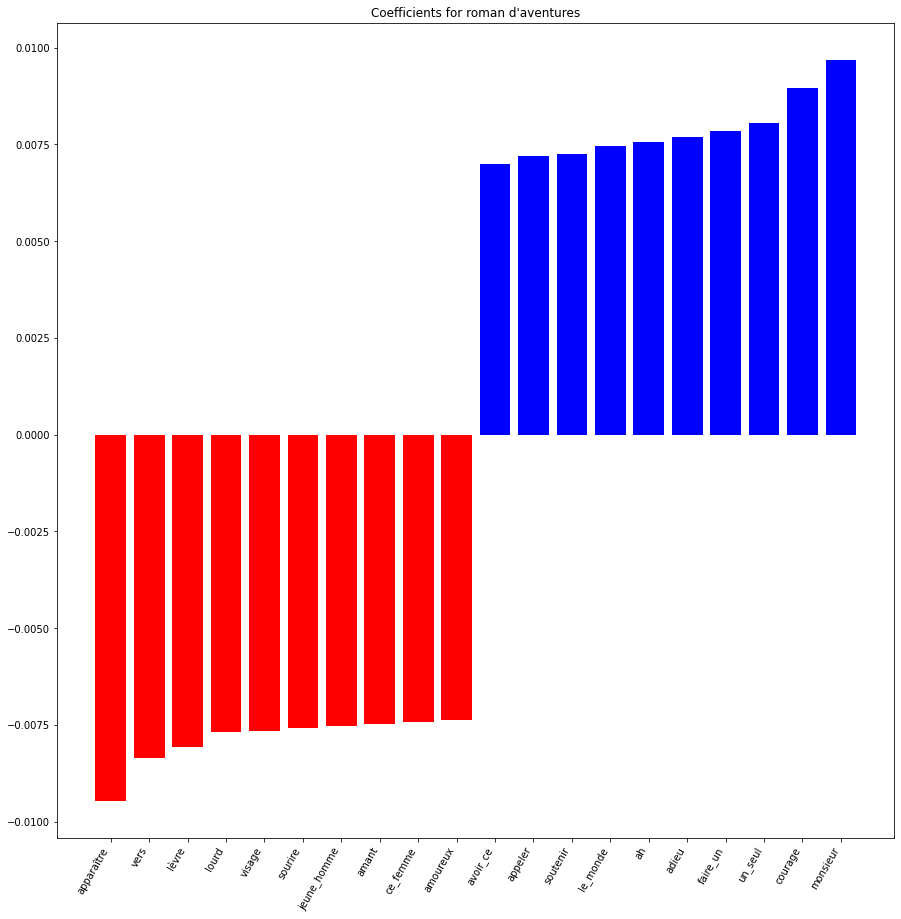

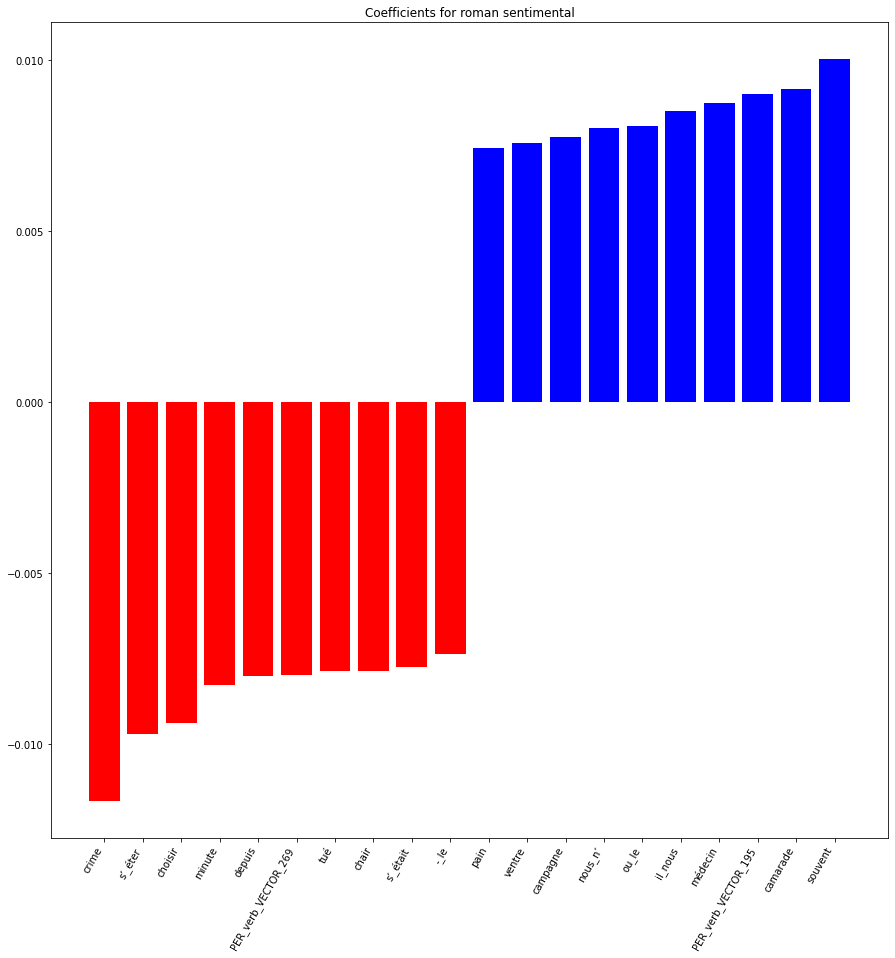

In [41]:
pipe, df_scores, bas = GKF_canonized(df_balanced, get_coefs=True, kernel="linear")

In [56]:
df_PER = df_balanced.iloc[:, 0:600]
df_PER['subgenre']=df_balanced['subgenre']
df_PER['auteur']=df_balanced['auteur']

0.3


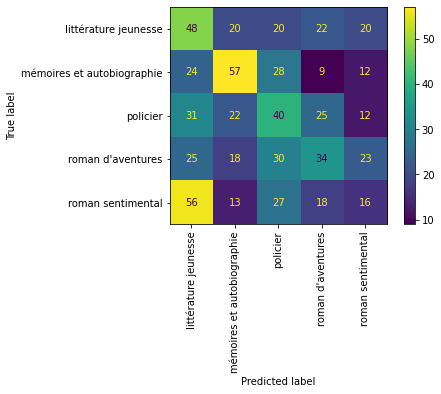

In [57]:
pipe, df_scores, bas = GKF_canonized(df_PER, kernel="linear")

In [58]:
df_CT= df_balanced.iloc[:, 600:1800]
df_CT['subgenre']=df_balanced['subgenre']
df_CT['auteur']=df_balanced['auteur']

0.48461538461538456


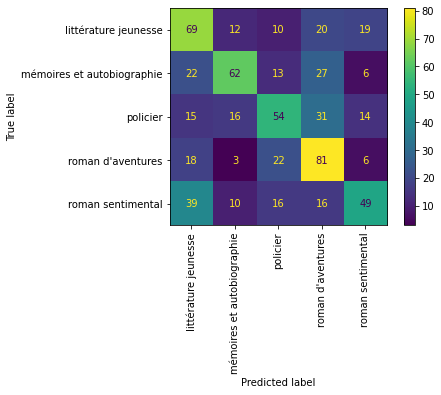

In [63]:
pipe, df_scores, bas = GKF_canonized(df_CT)

In [64]:
df_T= df_balanced.iloc[:, 1800:1833]
df_T['subgenre']=df_balanced['subgenre']
df_T['auteur']=df_balanced['auteur']

0.6061538461538462


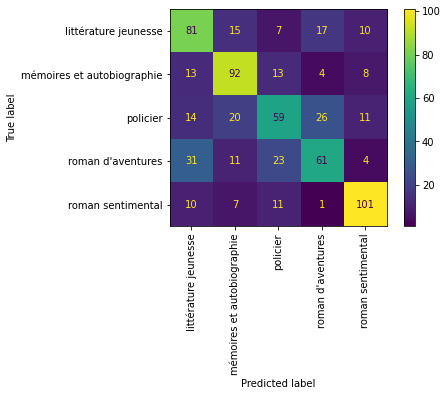

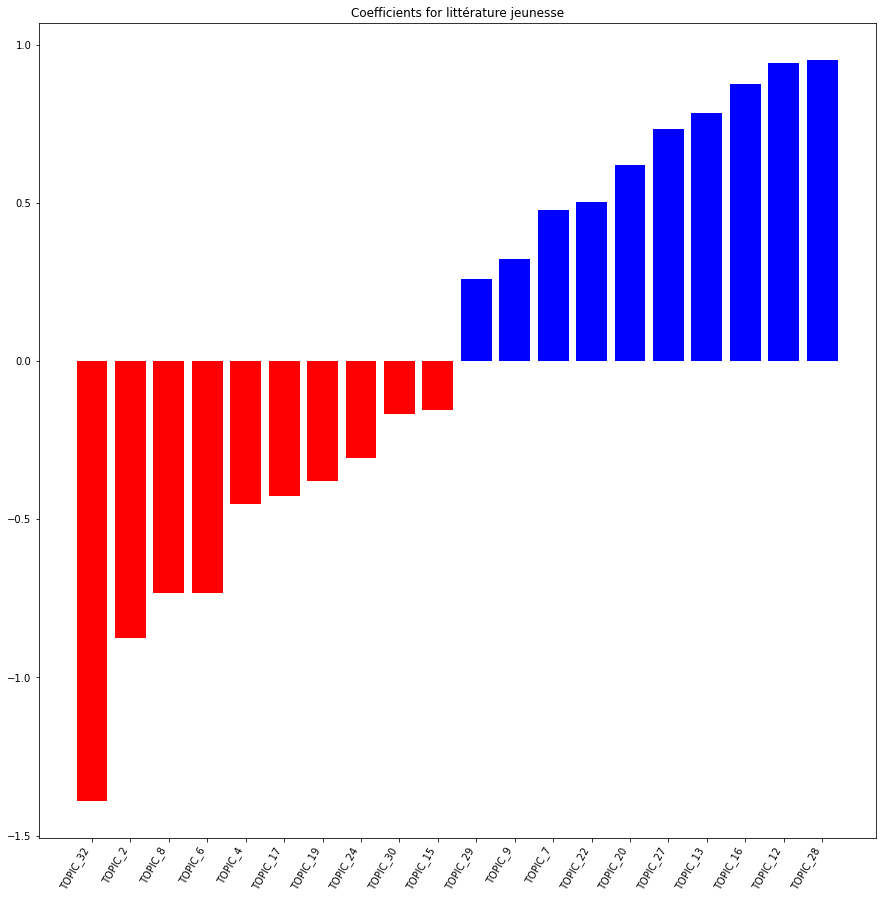

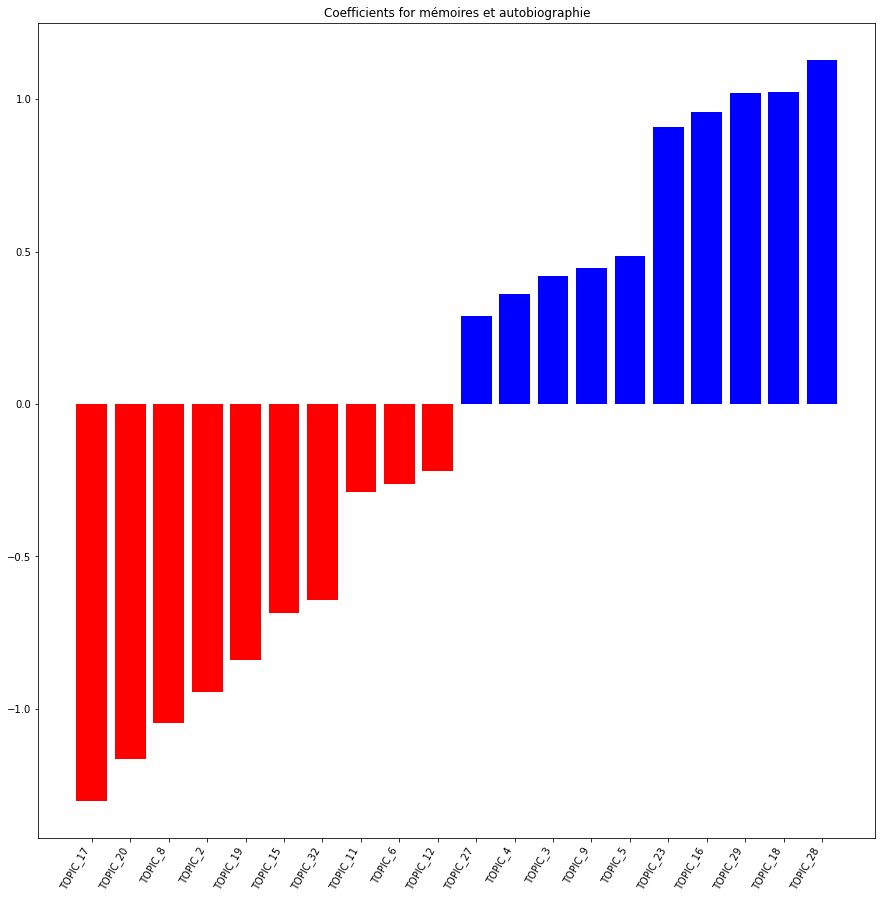

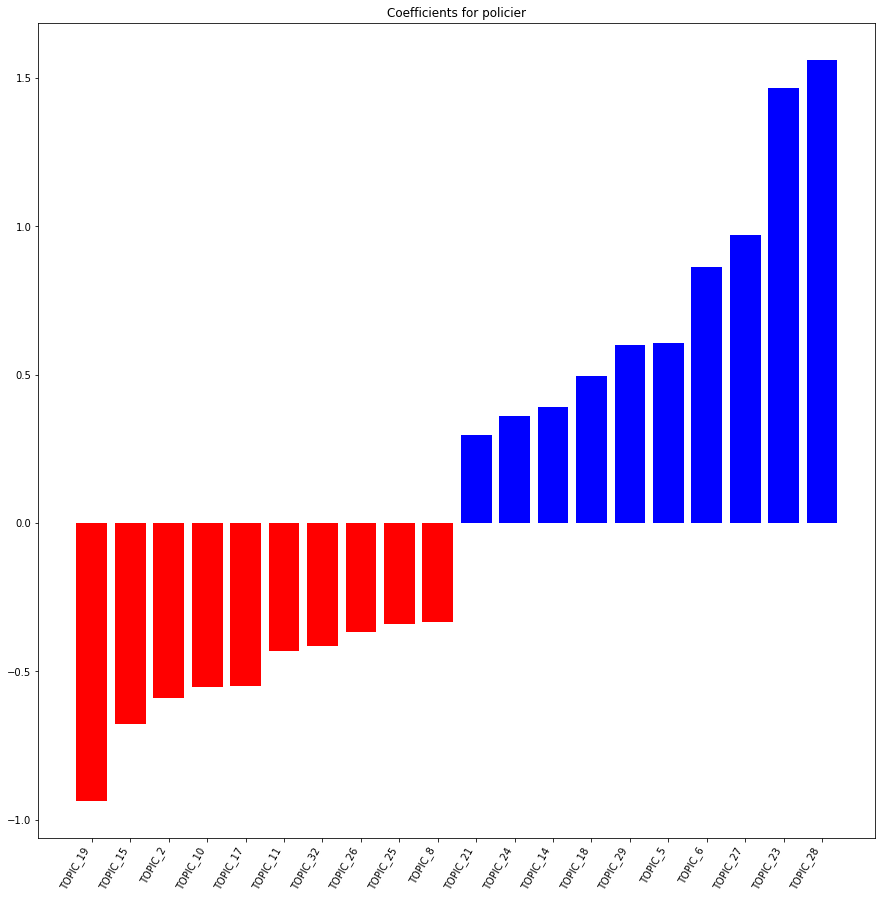

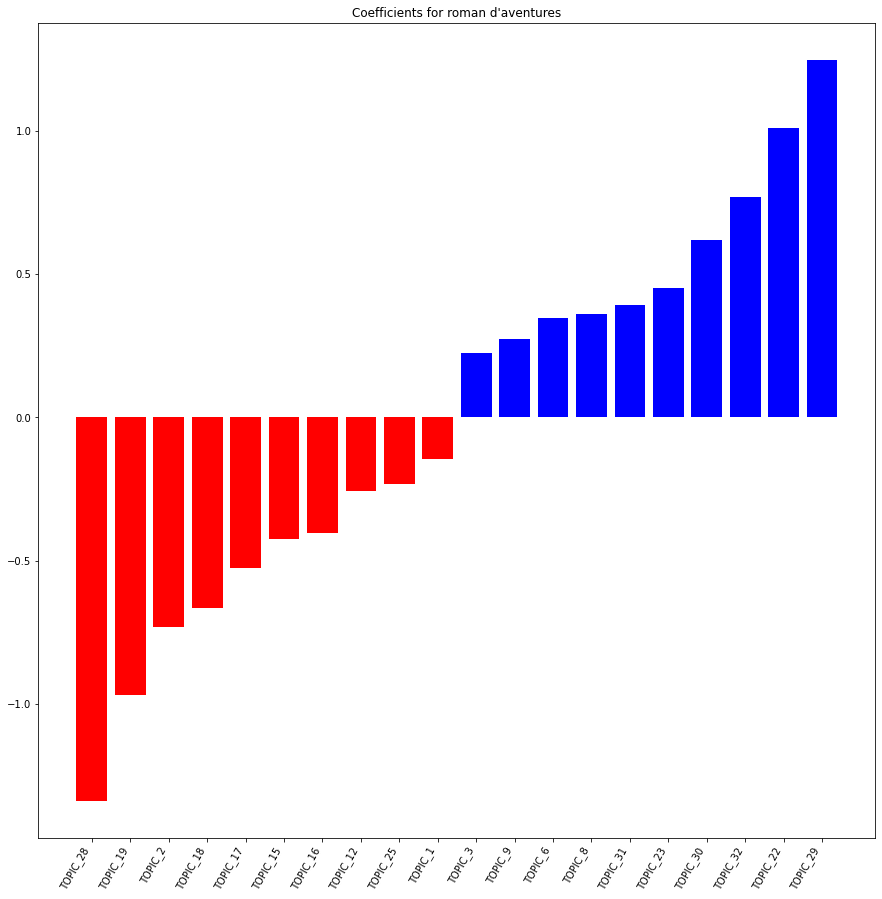

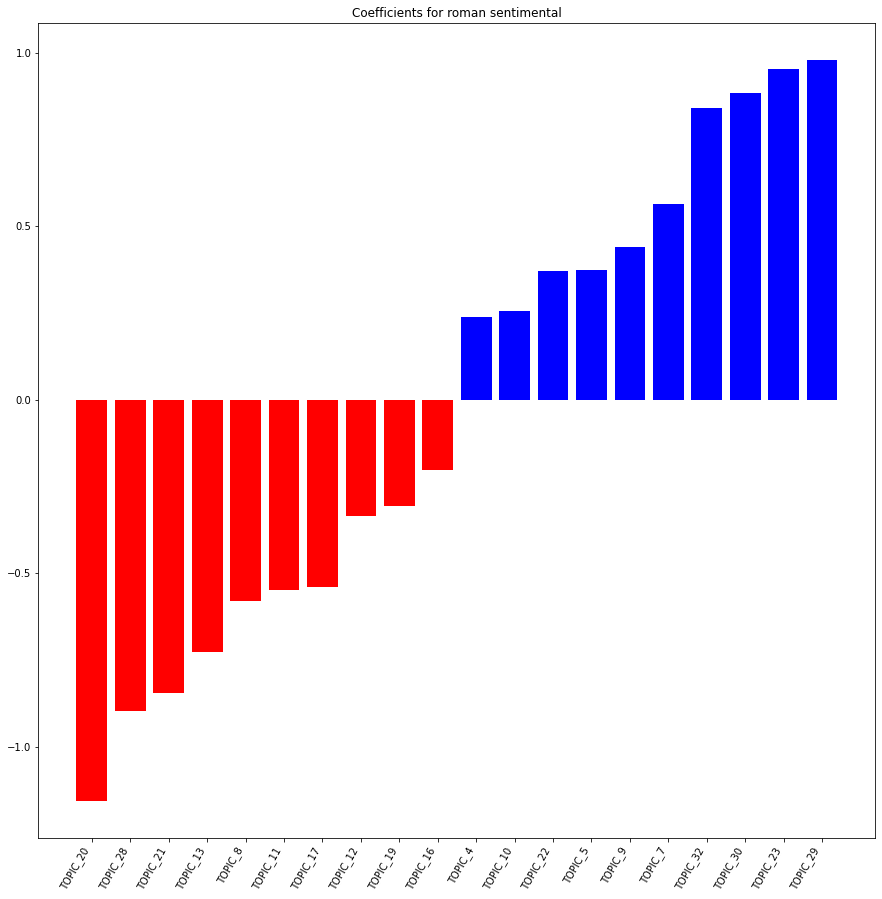

In [68]:
pipe, df_scores, bas = GKF_canonized(df_T,get_coefs=True, kernel="linear")

In [69]:
df_B = df_balanced.iloc[:, 1833:]

0.7738461538461539


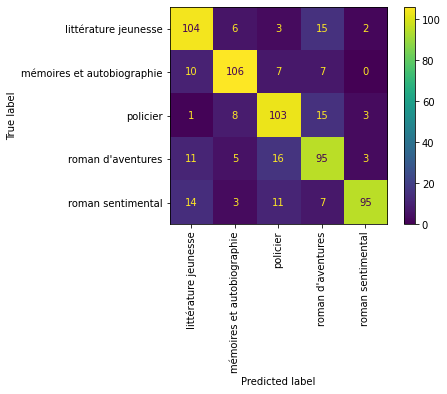

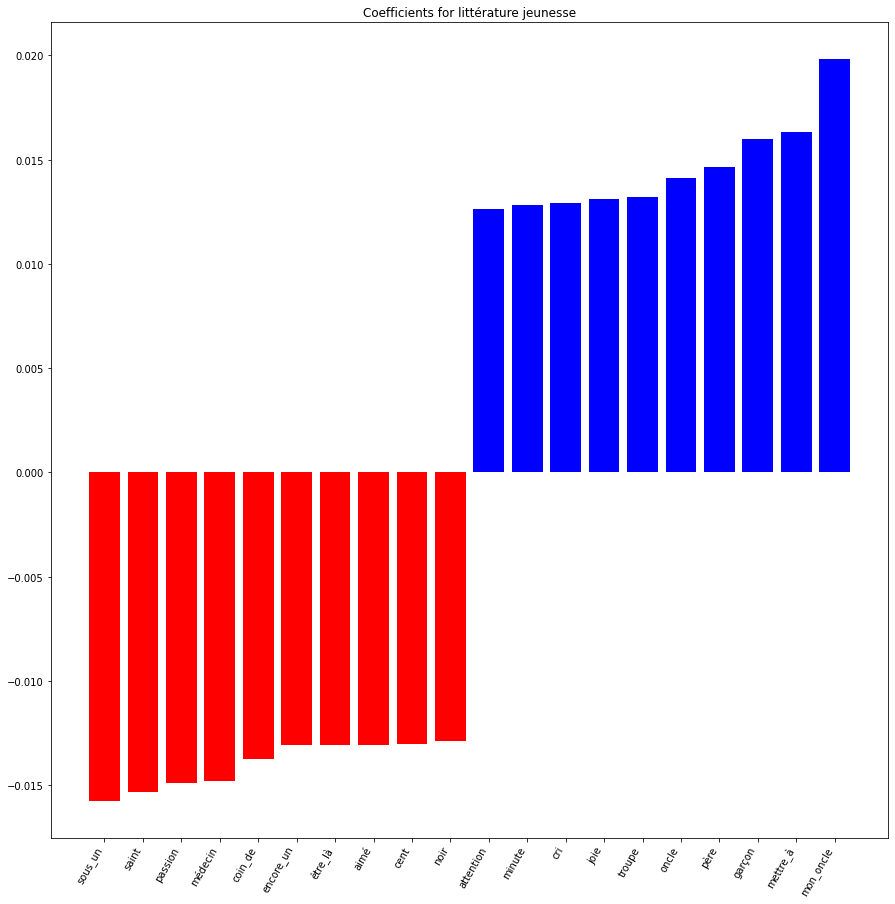

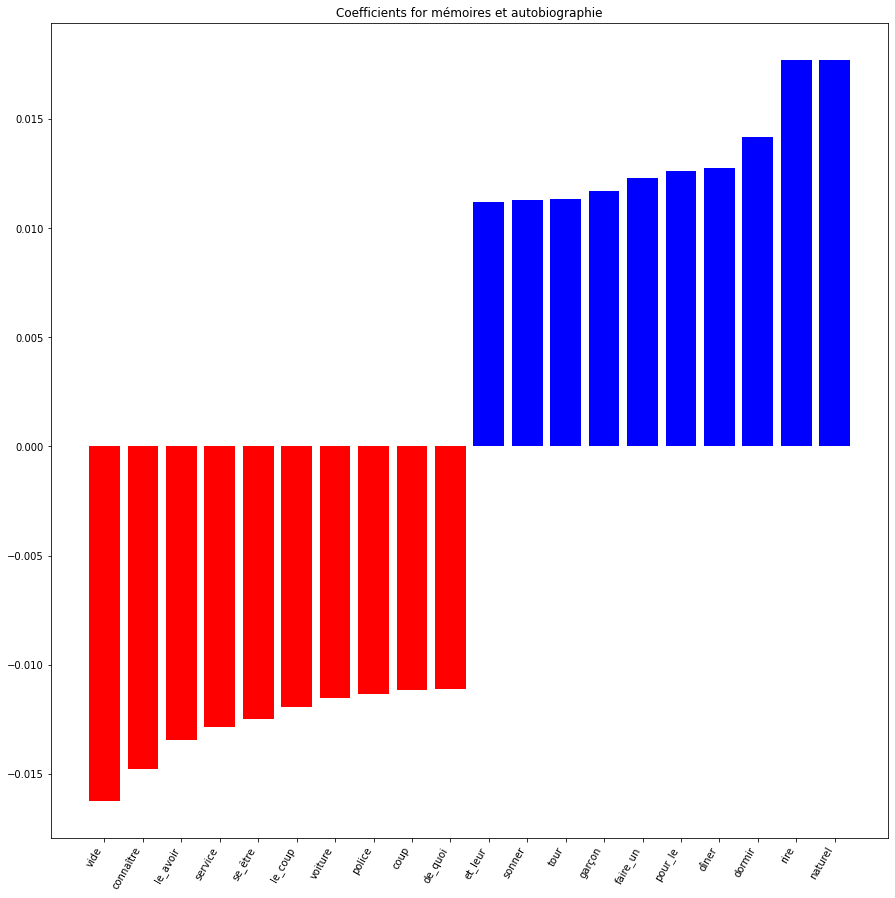

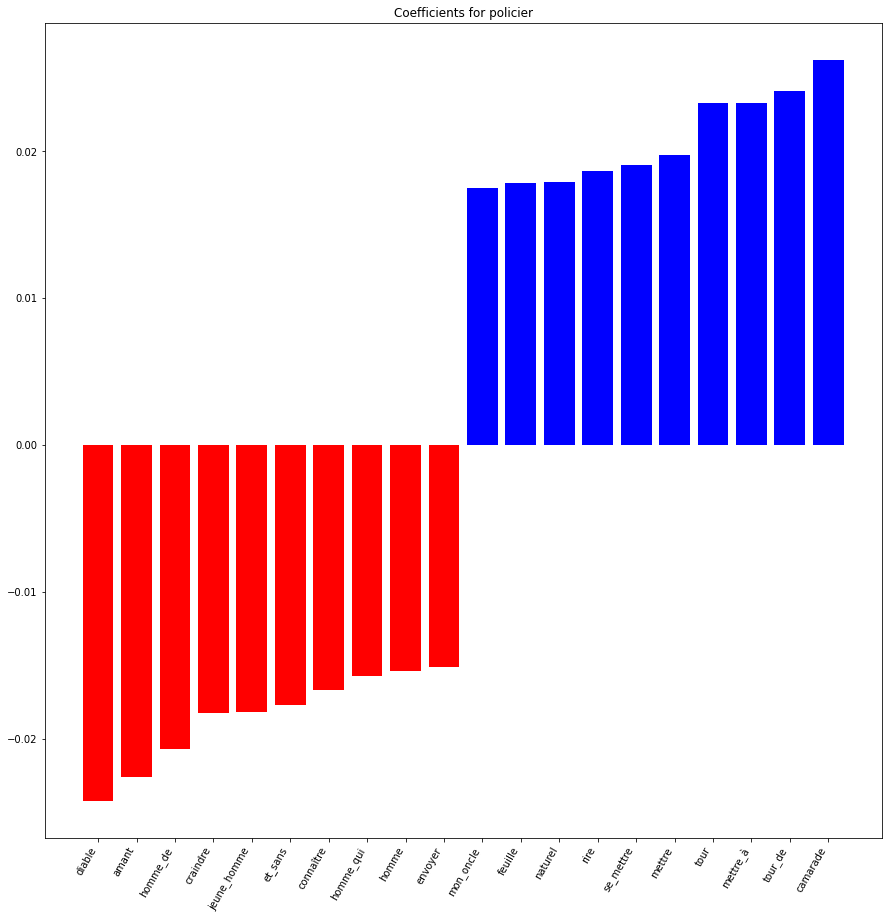

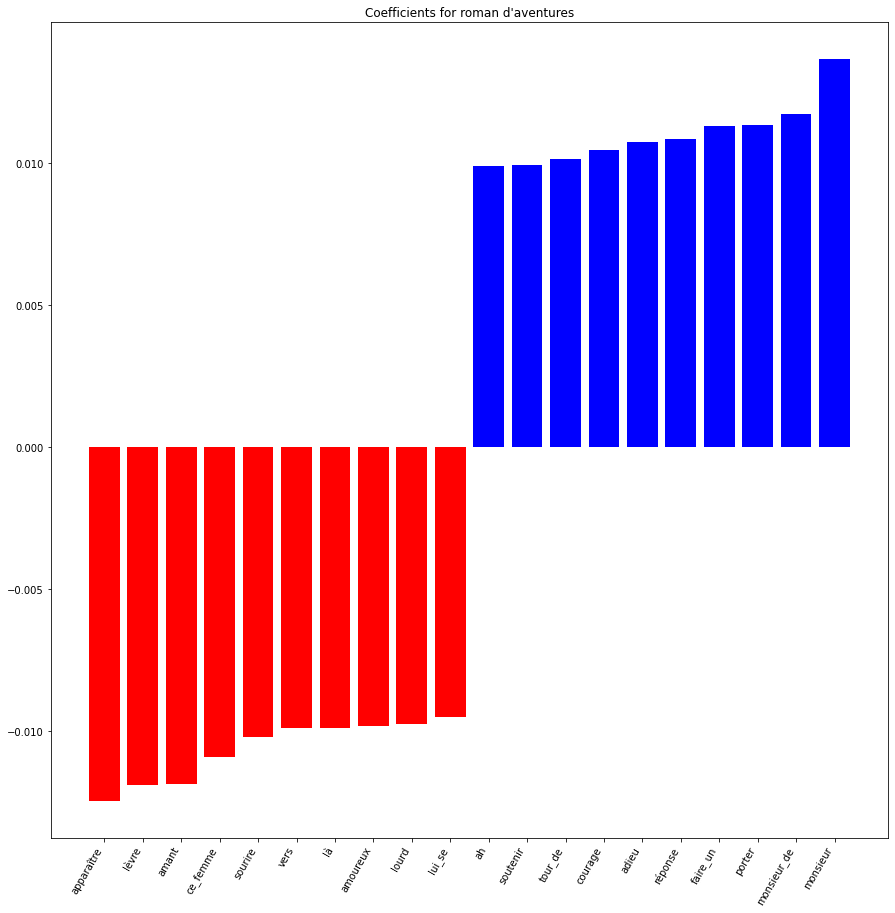

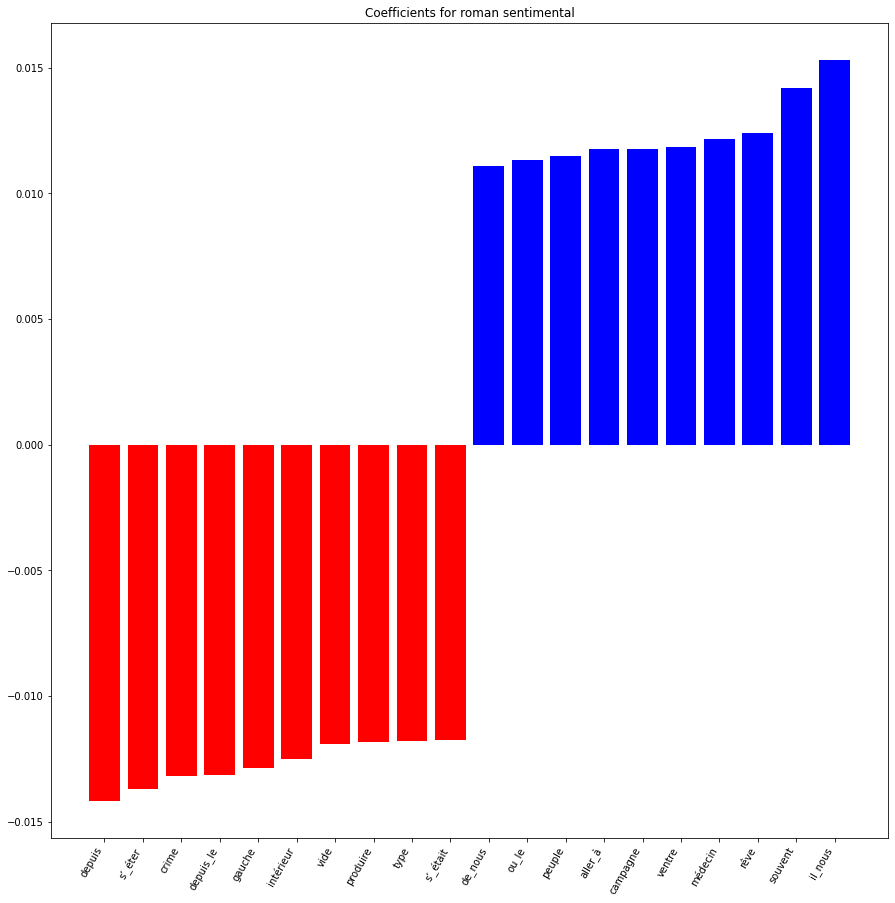

In [70]:
pipe, df_scores, bas = GKF_canonized(df_B, get_coefs=True, kernel="linear")